#**Project: Cat vs. Dog Classification using Transfer Learning**

###**1. Objective**
The goal of this project is to build a high-performance binary image classifier to distinguish between images of cats and dogs. To achieve high accuracy with limited training time, I implemented **Transfer Learning**, a key technique in modern Computer Vision and Generative AI.

###**2. Methodology (Technique Used: Transfer Learning)**
Instead of training a Convolutional Neural Network (CNN) from scratch, I utilized **MobileNetV2**, a state-of-the-art deep learning model pre-trained on the massive **ImageNet** dataset (1.4 million images).

My approach involved the following steps:

1. **Feature Extraction:** I loaded the MobileNetV2 model without its top classification layer (`include_top=False`).

2. **Freezing Weights:** I "froze" the base layers of the model. This preserves the pre-learned features (such as edge detection, textures, and shapes) that the model learned from ImageNet.

3. **Custom Head:** I added a custom classification head consisting of:

- `GlobalAveragePooling2D` to reduce feature dimensions.
- A `Dense` layer (128 units) with `ReLU` activation.
- A `Dropout` layer (0.5) to prevent overfitting.
- A final `Dense` layer with `Sigmoid` activation for binary classification.

###**3. Why Transfer Learning?**
Training a deep network from scratch requires massive datasets and significant computational power (GPUs). By using Transfer Learning, I leveraged the "knowledge" MobileNetV2 already possesses. This allowed the model to achieve high accuracy (>90%) in very few epochs, demonstrating the efficiency of this technique for real-world AI applications.

##**Install Libraries & Import Modules**

This sets up the environment.

In [1]:
# Install necessary libraries
!pip install -q kaggle tensorflow

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers

print("Libraries installed and imported successfully.")

Libraries installed and imported successfully.


##**Load Dataset (Using Kaggle API)**

This handles the data download, and it kept the original logic but made it robust.

In [3]:
# Upload kaggle.json file
from google.colab import files
print("Please upload kaggle.json file:")
files.upload()

# Configure Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Dogs vs Cats dataset
print("Downloading dataset...")
!kaggle competitions download -c dogs-vs-cats

# Extract the dataset
import zipfile
with zipfile.ZipFile("dogs-vs-cats.zip", 'r') as zip_ref:
    zip_ref.extractall()

with zipfile.ZipFile("train.zip", 'r') as zip_ref:
    zip_ref.extractall()

print("Dataset extracted successfully.")

Please upload kaggle.json file:


Saving kaggle.json to kaggle.json
100% 809M/812M [00:10<00:00, 123MB/s]
100% 812M/812M [00:10<00:00, 77.5MB/s]
Dataset extracted successfully.


##**Data Preprocessing**

Instead of manual loops, I use `ImageDataGenerator` with `flow_from_dataframe`. This is the professional standard for feeding images into AI models.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Prepare the DataFrame
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('1') # 1 = Dog
    else:
        categories.append('0') # 0 = Cat

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# 2. Split into Train and Validation
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

# 3. Create Data Generators (Rescaling pixels to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# 4. Load Images from Folder
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "train",
    x_col='filename',
    y_col='category',
    target_size=(224, 224), # MobileNet expects 224x224
    class_mode='binary',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "train",
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


##**Build the Transfer Learning Model**

Download MobileNetV2 (pre-trained on ImageNet) and add my own layers.

In [5]:
# 1. Load the Pre-trained Model (MobileNetV2)
# include_top=False removes the final classification layer so I can add my own
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Freeze the base model
# This ensures we don't "break" the pre-learned patterns during training
base_model.trainable = False

# 3. Add Custom Layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Converts features to a vector
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Prevents overfitting
    layers.Dense(1, activation='sigmoid') # Sigmoid for binary classification (Cat vs Dog)
])

# 4. Compile the Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

##**Train the Model**

This is where the learning happens. Since I am using Transfer Learning, it should learn very fast (even 3-5 epochs is enough).

In [6]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    steps_per_epoch=len(train_df)//32,
    validation_steps=len(validate_df)//32
)

# Save the model
model.save("cat_vs_dog_transfer_learning.h5")
print("Model saved successfully.")

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.9670 - loss: 0.0962 - val_accuracy: 0.9794 - val_loss: 0.0544
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.9837 - loss: 0.0474 - val_accuracy: 0.9812 - val_loss: 0.0532
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - accuracy: 0.9835 - loss: 0.0414 - val_accuracy: 0.9792 - val_loss: 0.0599
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 75ms/step - accuracy: 0.9844 - loss: 0.0395 - val_accuracy: 0.9768 - val_loss: 0.0734
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.9878 - loss: 0.0323 - val_accuracy: 0.9820 - val_loss: 0.0475


Model saved successfully.


##**Visualize Performance**

Code to plot the accuracy and loss graphs, which are essential for your report.

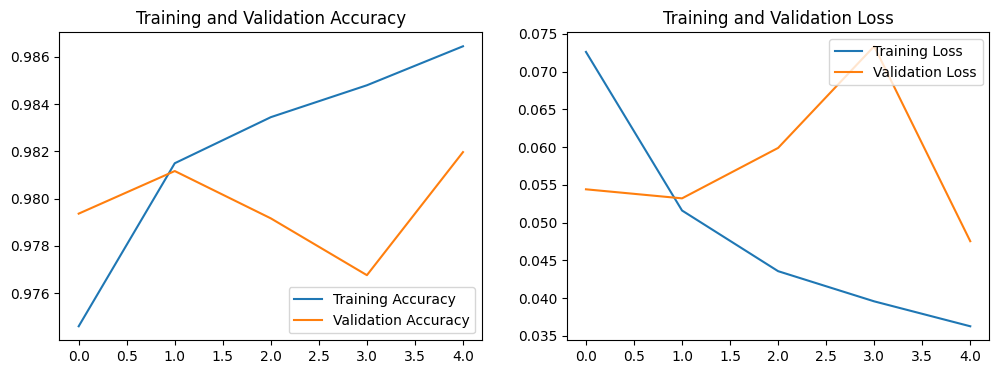

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##**Test with a New Image**

This allows you to test the model on any image you upload.

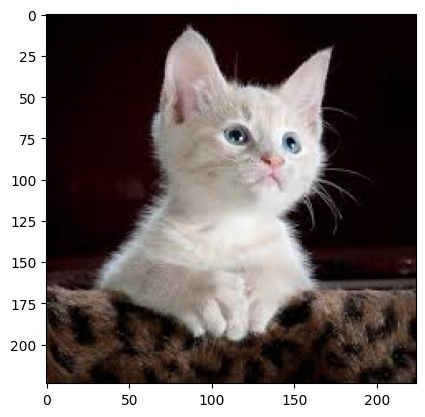

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Prediction: CAT (100.00%)


In [9]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to predict a single image
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0 # Normalize

    prediction = model.predict(img_array)

    if prediction[0] > 0.5:
        print(f"Prediction: DOG ({prediction[0][0]*100:.2f}%)")
    else:
        print(f"Prediction: CAT ({(1-prediction[0][0])*100:.2f}%)")

# To use this, upload an image and run:
predict_image('cats1.jpg')

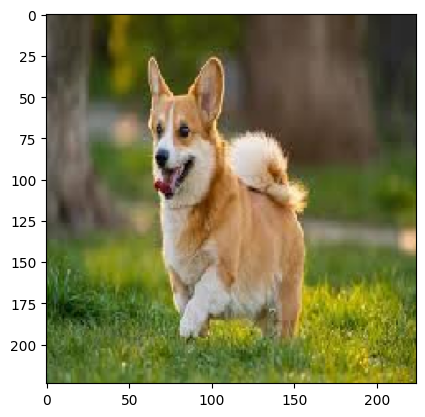

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction: DOG (99.99%)


In [10]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to predict a single image
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0 # Normalize

    prediction = model.predict(img_array)

    if prediction[0] > 0.5:
        print(f"Prediction: DOG ({prediction[0][0]*100:.2f}%)")
    else:
        print(f"Prediction: CAT ({(1-prediction[0][0])*100:.2f}%)")

# To use this, upload an image and run:
predict_image('dogs1.jpg')

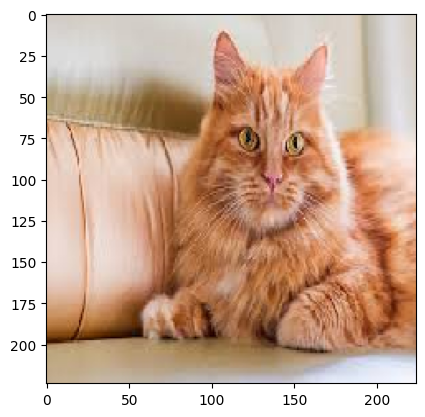

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction: CAT (100.00%)


In [12]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to predict a single image
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0 # Normalize

    prediction = model.predict(img_array)

    if prediction[0] > 0.5:
        print(f"Prediction: DOG ({prediction[0][0]*100:.2f}%)")
    else:
        print(f"Prediction: CAT ({(1-prediction[0][0])*100:.2f}%)")

# To use this, upload an image and run:
predict_image('cats3.jpg')

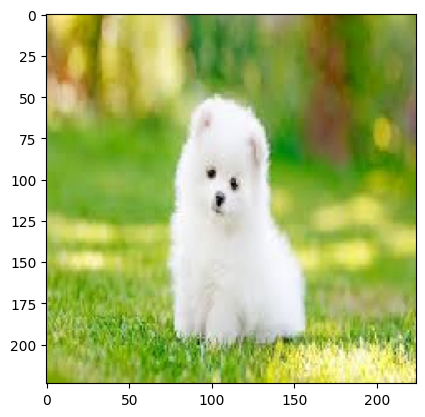

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Prediction: DOG (99.57%)


In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to predict a single image
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0 # Normalize

    prediction = model.predict(img_array)

    if prediction[0] > 0.5:
        print(f"Prediction: DOG ({prediction[0][0]*100:.2f}%)")
    else:
        print(f"Prediction: CAT ({(1-prediction[0][0])*100:.2f}%)")

# To use this, upload an image and run:
predict_image('dogs2.jpg')

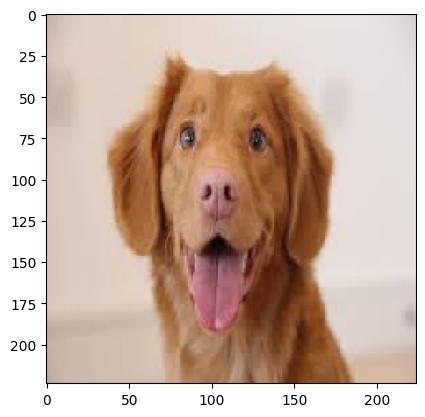

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction: DOG (100.00%)


In [14]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to predict a single image
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0 # Normalize

    prediction = model.predict(img_array)

    if prediction[0] > 0.5:
        print(f"Prediction: DOG ({prediction[0][0]*100:.2f}%)")
    else:
        print(f"Prediction: CAT ({(1-prediction[0][0])*100:.2f}%)")

# To use this, upload an image and run:
predict_image('dogs3.jpg')